In [1]:
# -*- coding: utf-8 -*-
"""Copy of Employee_salary_predictions123.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1tsY0Fwh2e3DeGDPRil24pXAjWhjSgrOd
"""

# Install necessary libraries if not already installed
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras xgboost lightgbm joblib


In [2]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
import lightgbm as lgb
import warnings
import joblib # Added for saving models and scaler
import os # Added to check file existence

In [3]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [6]:
# --- Helper Functions for Data Handling and Model Training ---

# This function encapsulates data loading and preprocessing steps.
# In a Streamlit app, you would typically decorate this with @st.cache_data
# to avoid re-running expensive computations on each rerun.
def load_and_preprocess_data(file_path='employee_salary_large.csv'):
    if not os.path.exists(file_path):
        print(f"Error: '{file_path}' not found. Please upload the data file.")
        # In a Colab environment, you might need to upload the file manually
        # or use files.upload()
        return None, None, None, None, None, None, None, None

    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip() # Clean column names

    print("Initial Data Info:")
    print(df.info())
    print("\nInitial Data Description:")
    print(df.describe())
    print("\nMissing values before preprocessing:")
    print(df.isnull().sum())

    # 1. Handle Outliers (using IQR for numerical columns)
    numerical_cols_for_outliers = df.select_dtypes(include=np.number).columns.tolist()
    if 'RemoteWork' in numerical_cols_for_outliers:
        numerical_cols_for_outliers.remove('RemoteWork')
    if 'Salary' in numerical_cols_for_outliers:
        numerical_cols_for_outliers.remove('Salary') # Exclude target from outlier treatment

    for col in numerical_cols_for_outliers:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    print("\nOutliers handled for numerical columns using IQR capping.")

    # Address negative salaries by setting them to a minimum reasonable value (e.g., 0)
    if (df['Salary'] < 0).any():
        print(f"\nFound {len(df[df['Salary'] < 0])} negative salaries. Capping them at 0.")
        df['Salary'] = np.where(df['Salary'] < 0, 0, df['Salary'])
    print("Salary column description after handling negative values:")
    print(df['Salary'].describe())

    # 2. Feature Engineering
    df['Experience_Age_Ratio'] = df['YearsExperience'] / df['Age']
    df['Experience_Age_Ratio'].fillna(0, inplace=True)

    df['Total_Skills_Certifications'] = df['Certifications'] + df['EducationLevel']

    df['Productivity_Score'] = df['PerformanceRating'] * (df['WorkingHours'] / (df['LeavesTaken'] + 1e-6))
    df['Productivity_Score'].fillna(0, inplace=True)
    print("\nNew features created: Experience_Age_Ratio, Total_Skills_Certifications, Productivity_Score.")

    # 3. Encoding Categorical Features
    categorical_cols = df.select_dtypes(include='object').columns
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    print("\nDataFrame after One-Hot Encoding Head:")
    print(df_encoded.head())

    # Define features (X) and target (y)
    X = df_encoded.drop('Salary', axis=1)
    y = df_encoded['Salary']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 4. Scaling Numerical Features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    print("\nData splitting and scaling complete.")
    return df, X_train_scaled_df, X_test_scaled_df, y_train, y_test, scaler, X.columns, categorical_cols


In [7]:
# This function encapsulates model training.
# In a Streamlit app, you would typically decorate this with @st.cache_resource
# to ensure models are trained only once.
def train_all_models(X_train, y_train):
    models = {}

    print("\n--- Training Models ---")

    # 1. Linear Regression
    print("Training Linear Regression...")
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    models["Linear Regression"] = lr_model

    # 2. Random Forest
    print("Training Random Forest (GridSearch)...")
    param_grid_rf = {'n_estimators': [100, 150], 'max_depth': [10, 15]} # Simplified for faster training
    rf_model = RandomForestRegressor(random_state=42)
    grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf,
                                  cv=KFold(n_splits=3, shuffle=True, random_state=42),
                                  n_jobs=-1, verbose=0, scoring='r2')
    grid_search_rf.fit(X_train, y_train)
    models["Random Forest"] = grid_search_rf.best_estimator_

    # 3. Gradient Boosting
    print("Training Gradient Boosting (GridSearch)...")
    param_grid_gb = {'n_estimators': [100, 150], 'learning_rate': [0.05, 0.1]} # Simplified
    gb_model = GradientBoostingRegressor(random_state=42)
    grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb,
                                  cv=KFold(n_splits=3, shuffle=True, random_state=42),
                                  n_jobs=-1, verbose=0, scoring='r2')
    grid_search_gb.fit(X_train, y_train)
    models["Gradient Boosting"] = grid_search_gb.best_estimator_

    # 4. XGBoost
    print("Training XGBoost (GridSearch)...")
    param_grid_xgb = {'n_estimators': [100, 150], 'learning_rate': [0.05, 0.1]} # Simplified
    xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror', verbosity=0)
    grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb,
                                   cv=KFold(n_splits=3, shuffle=True, random_state=42),
                                   n_jobs=-1, verbose=0, scoring='r2')
    grid_search_xgb.fit(X_train, y_train)
    models["XGBoost"] = grid_search_xgb.best_estimator_

    # 5. LightGBM
    print("Training LightGBM (GridSearch)...")
    param_grid_lgb = {'n_estimators': [100, 150], 'learning_rate': [0.05, 0.1]} # Simplified
    lgb_model = lgb.LGBMRegressor(random_state=42, verbose=-1)
    grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid_lgb,
                                   cv=KFold(n_splits=3, shuffle=True, random_state=42),
                                   n_jobs=-1, verbose=0, scoring='r2')
    grid_search_lgb.fit(X_train, y_train)
    models["LightGBM"] = grid_search_lgb.best_estimator_

    # 6. Deep Learning Model
    print("Training Deep Learning Model...")
    dl_model = Sequential()
    dl_model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
    dl_model.add(Dropout(0.2))
    dl_model.add(Dense(128, activation='relu'))
    dl_model.add(Dropout(0.2))
    dl_model.add(Dense(64, activation='relu'))
    dl_model.add(Dense(1))
    dl_model.compile(optimizer='adam', loss='mean_squared_error')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    dl_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
    models["Deep Learning"] = dl_model

    print("All models trained!")
    return models

In [13]:
def evaluate_model_metrics(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    mask = y_true != 0
    if y_true[mask].empty:
        mape = np.nan
    else:
        mape = mean_absolute_percentage_error(y_true[mask], y_pred[mask])

    return {
        "Model": name,
        "R2 Score": round(r2, 4),
        "MSE": round(mse, 2),
        "MAE": round(mae, 2),
        "MAPE (%)": round(mape * 100, 2) if not np.isnan(mape) else np.nan
    }


In [14]:
print("--- Starting Employee Salary Prediction Notebook Execution ---")

# Load and preprocess data
df, X_train_scaled_df, X_test_scaled_df, y_train, y_test, scaler, train_cols, categorical_cols = load_and_preprocess_data()

if df is None:
    print("Data loading failed. Please ensure 'employee_salary_large.csv' is uploaded. Exiting notebook execution.")
else:
    print("\n--- Data Preprocessing Complete ---")


--- Starting Employee Salary Prediction Notebook Execution ---
Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   YearsExperience    40000 non-null  int64  
 1   EducationLevel     40000 non-null  int64  
 2   Age                40000 non-null  int64  
 3   JobRole            40000 non-null  object 
 4   Location           40000 non-null  object 
 5   Certifications     40000 non-null  int64  
 6   PreviousCompanies  40000 non-null  int64  
 7   PerformanceRating  40000 non-null  int64  
 8   TechStack          40000 non-null  object 
 9   Department         40000 non-null  object 
 10  WorkingHours       40000 non-null  int64  
 11  LeavesTaken        40000 non-null  int64  
 12  Gender             40000 non-null  object 
 13  EmploymentType     40000 non-null  object 
 14  RemoteWork         40000 non-null  i


--- Enhanced Data Visualization ---

Generating Pairplot (sampling 1000 rows for large dataset)...


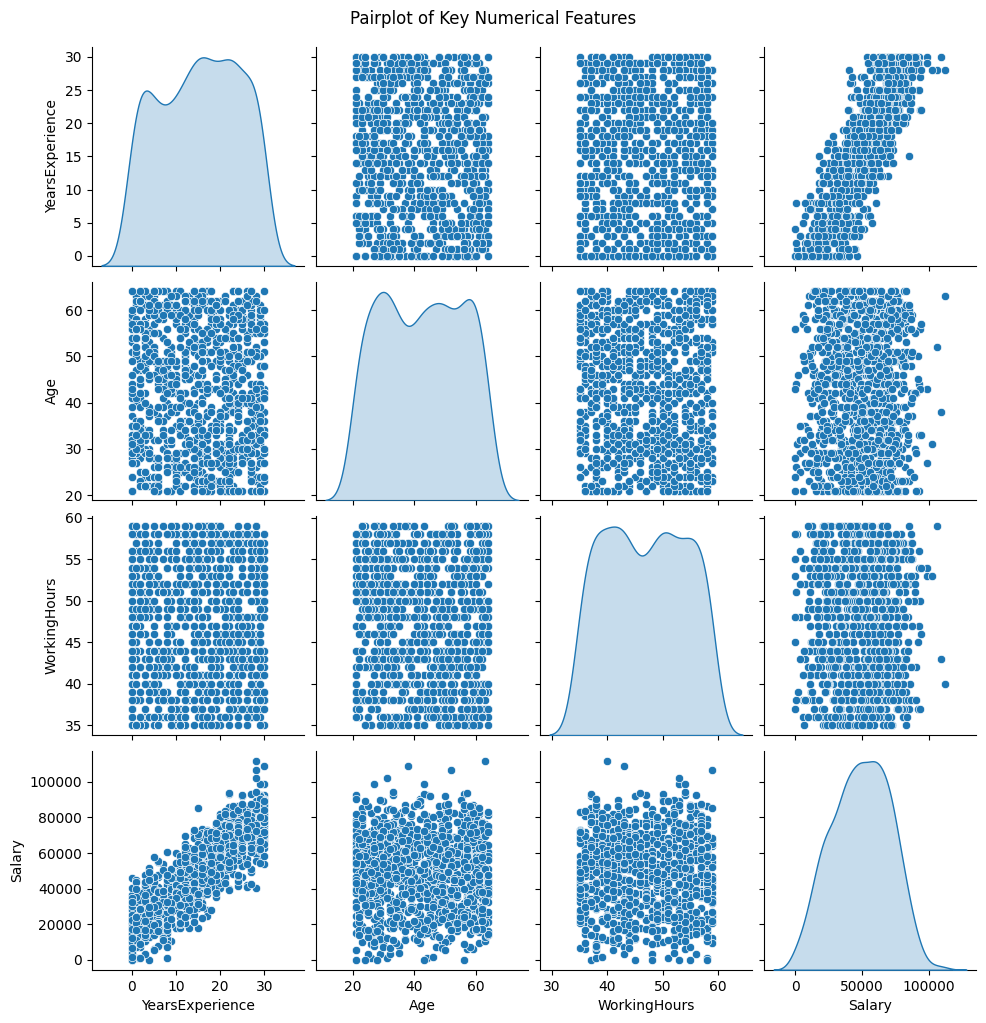


Generating Box Plots for Categorical Features vs. Salary...


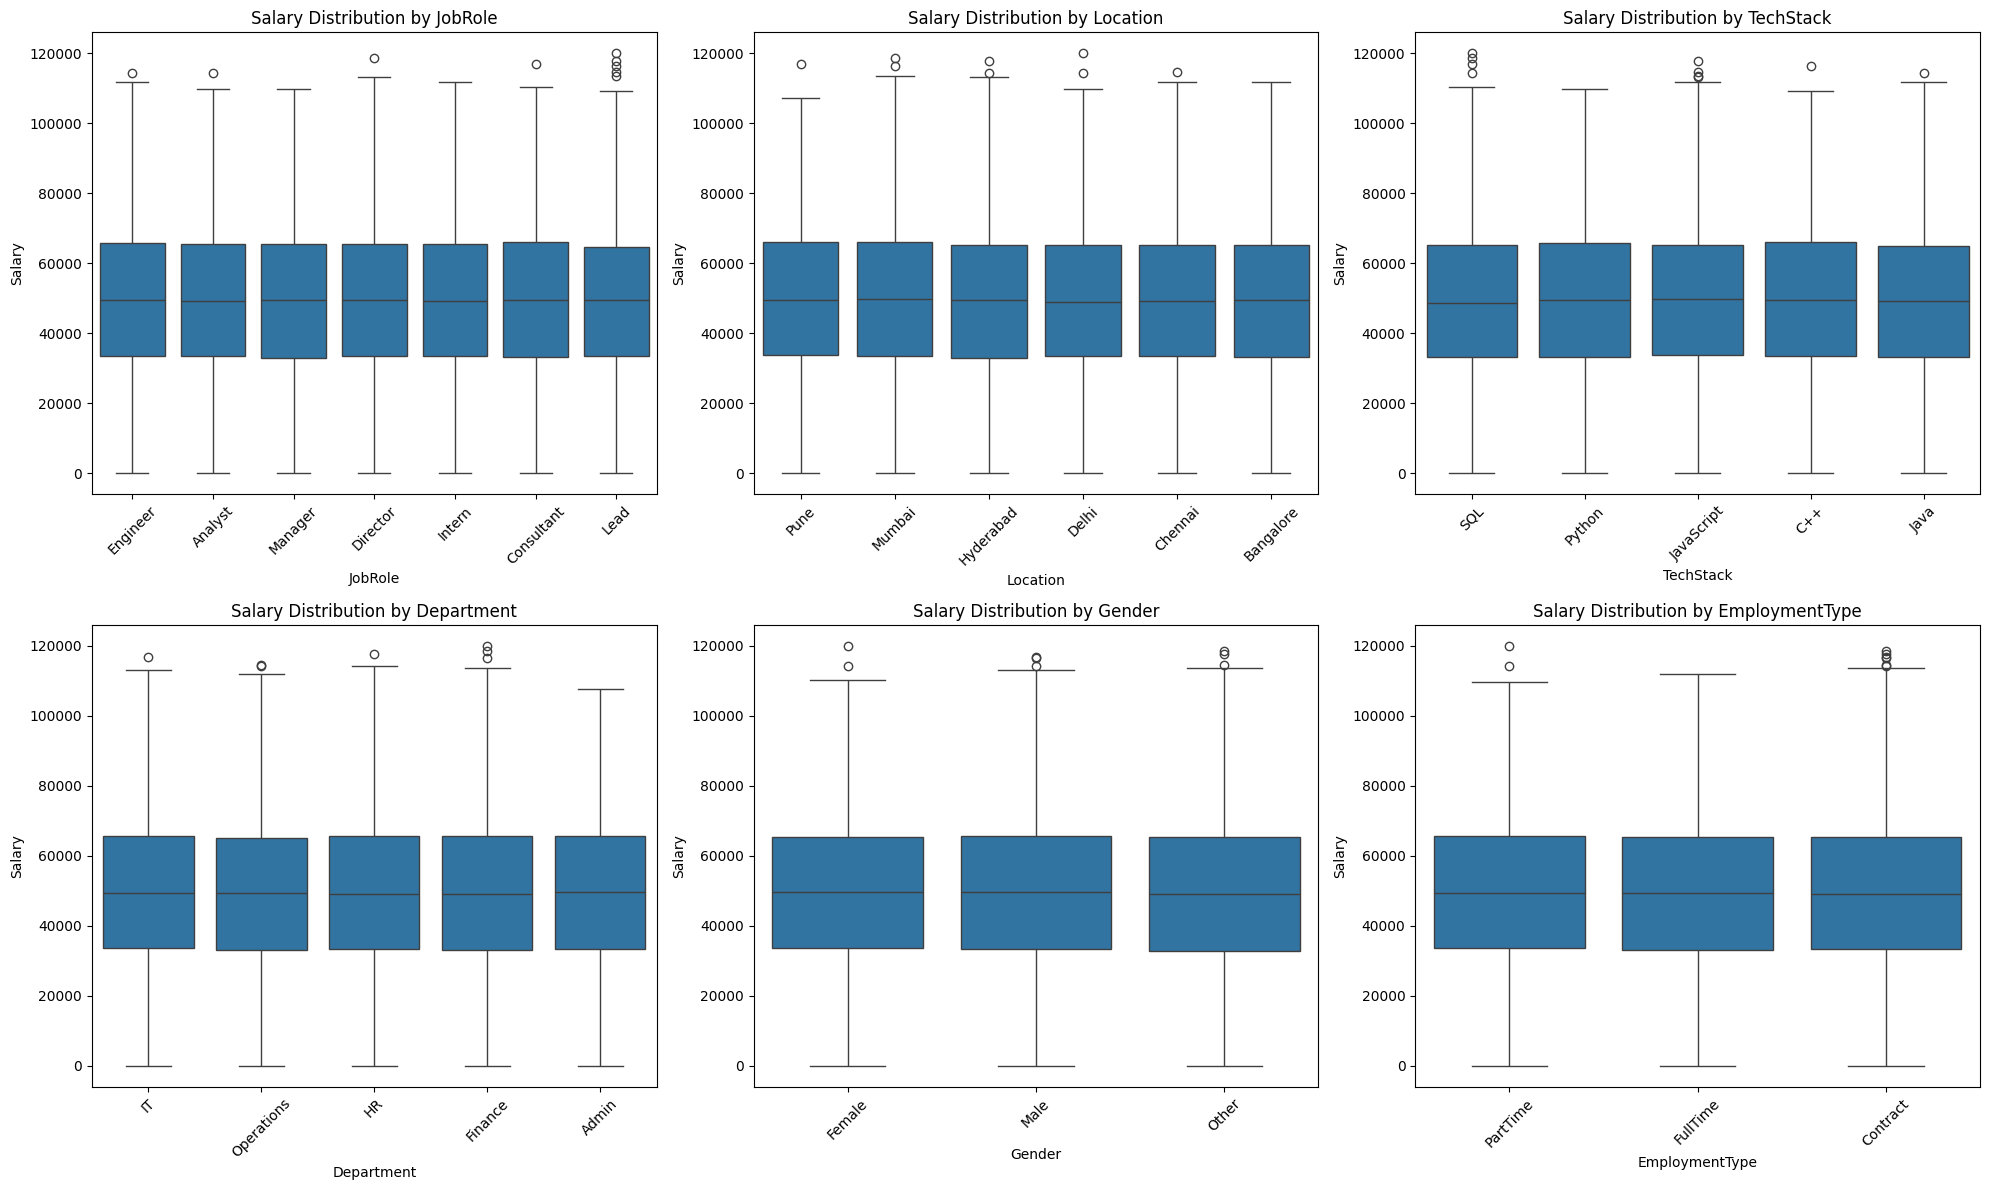


Generating Correlation Matrix Heatmap...


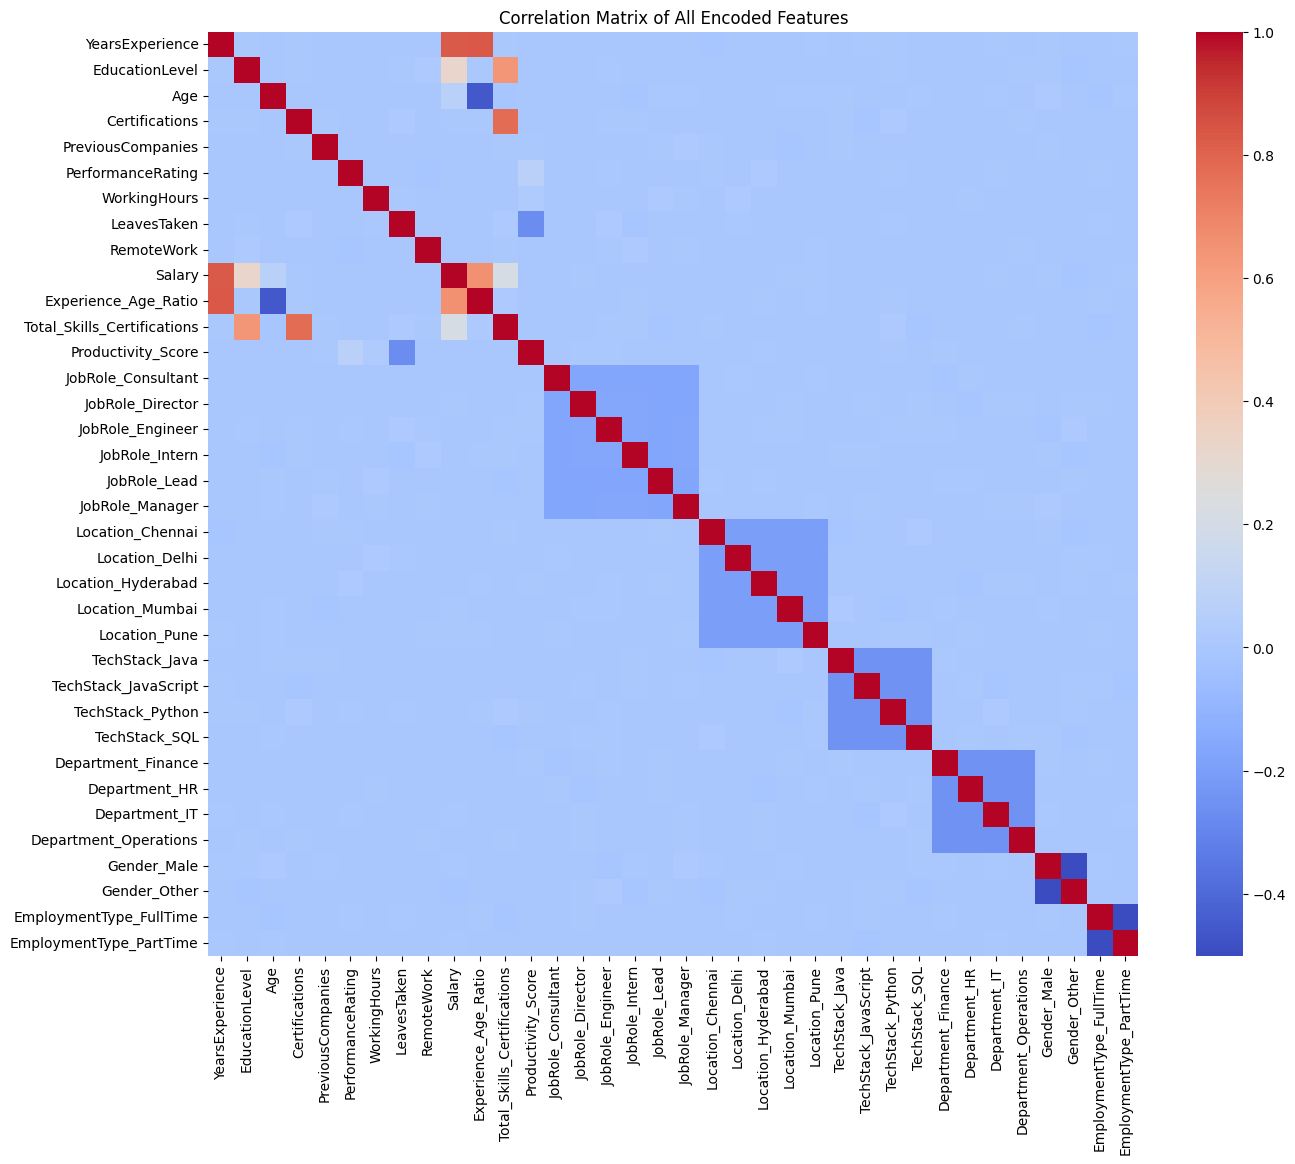


Generating Histograms for Engineered Features...



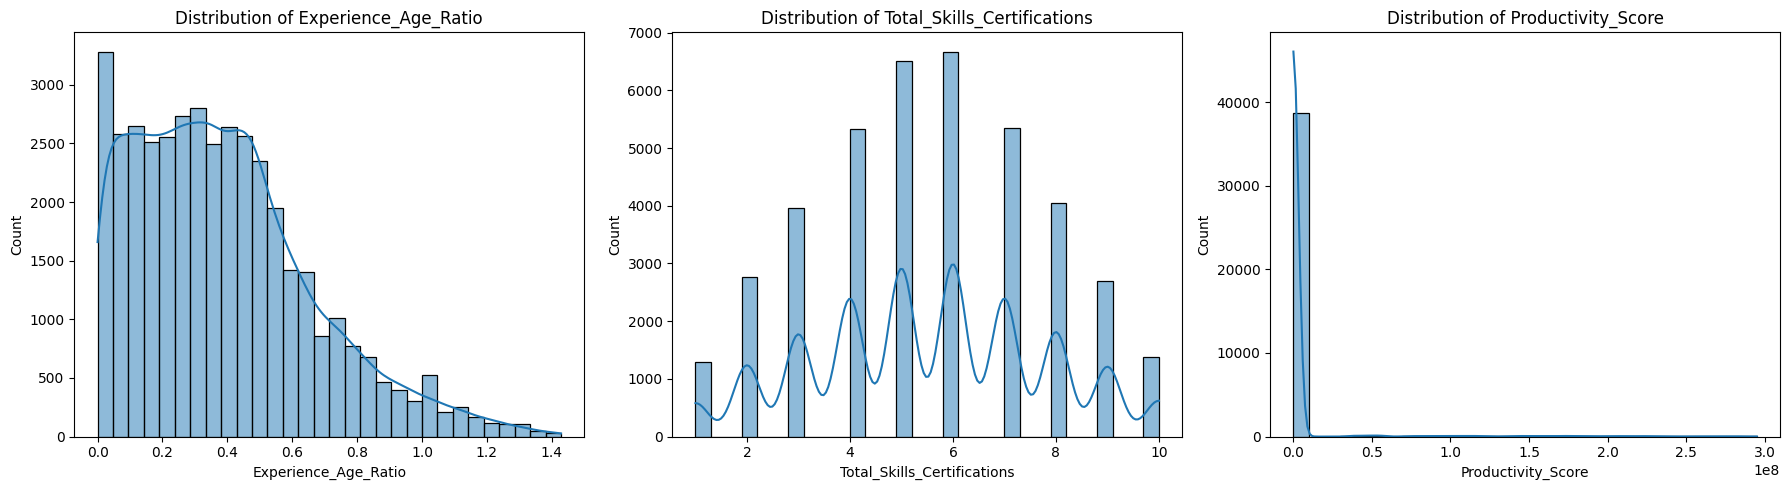

In [15]:
if df is not None: # Only proceed if data loaded successfully
    print("\n--- Enhanced Data Visualization ---")
    print("\nGenerating Pairplot (sampling 1000 rows for large dataset)...")
    sns.pairplot(df.sample(min(1000, len(df))), vars=['YearsExperience', 'Age', 'WorkingHours', 'Salary'], diag_kind='kde')
    plt.suptitle('Pairplot of Key Numerical Features', y=1.02)
    plt.show()

    print("\nGenerating Box Plots for Categorical Features vs. Salary...")
    fig_box, axes_box = plt.subplots(2, 3, figsize=(20, 12))
    axes_box = axes_box.flatten()
    for i, col in enumerate(categorical_cols):
        if i < len(axes_box):
            sns.boxplot(x=col, y='Salary', data=df, ax=axes_box[i])
            axes_box[i].set_title(f'Salary Distribution by {col}')
            axes_box[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

    print("\nGenerating Correlation Matrix Heatmap...")
    df_encoded_full = pd.get_dummies(df, columns=categorical_cols, drop_first=True) # Full encoded df for heatmap
    plt.figure(figsize=(15, 12))
    sns.heatmap(df_encoded_full.corr(numeric_only=True), annot=False, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix of All Encoded Features")
    plt.show()

    print("\nGenerating Histograms for Engineered Features...\n")
    fig_hist, axes_hist = plt.subplots(1, 3, figsize=(18, 5))
    sns.histplot(df['Experience_Age_Ratio'], bins=30, kde=True, ax=axes_hist[0])
    axes_hist[0].set_title('Distribution of Experience_Age_Ratio')
    sns.histplot(df['Total_Skills_Certifications'], bins=30, kde=True, ax=axes_hist[1])
    axes_hist[1].set_title('Distribution of Total_Skills_Certifications')
    sns.histplot(df['Productivity_Score'], bins=30, kde=True, ax=axes_hist[2])
    axes_hist[2].set_title('Distribution of Productivity_Score')
    plt.tight_layout()
    plt.show()


In [16]:
if df is not None: # Only proceed if data loaded successfully
    trained_models = train_all_models(X_train_scaled_df, y_train)


--- Training Models ---
Training Linear Regression...
Training Random Forest (GridSearch)...
Training Gradient Boosting (GridSearch)...
Training XGBoost (GridSearch)...
Training LightGBM (GridSearch)...
Training Deep Learning Model...
All models trained!



--- Model Accuracy Report (Evaluated on Test Set) ---
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Note: Accuracy metrics (R2, MSE, MAE, MAPE) are calculated on the test set where actual salaries are known.
               Model  R2 Score           MSE      MAE  MAPE (%)
0  Linear Regression    0.7882  9.835388e+07  7906.84     30.91
1      Random Forest    0.7810  1.017045e+08  8050.74     31.42
2  Gradient Boosting    0.7872  9.883018e+07  7930.94     31.53
3            XGBoost    0.7853  9.974419e+07  7964.01     31.60
4           LightGBM    0.7863  9.926133e+07  7951.73     31.68
5      Deep Learning    0.7768  1.036627e+08  8141.08     34.36

Plotting Model Comparison - R2 Score (on Test Set)


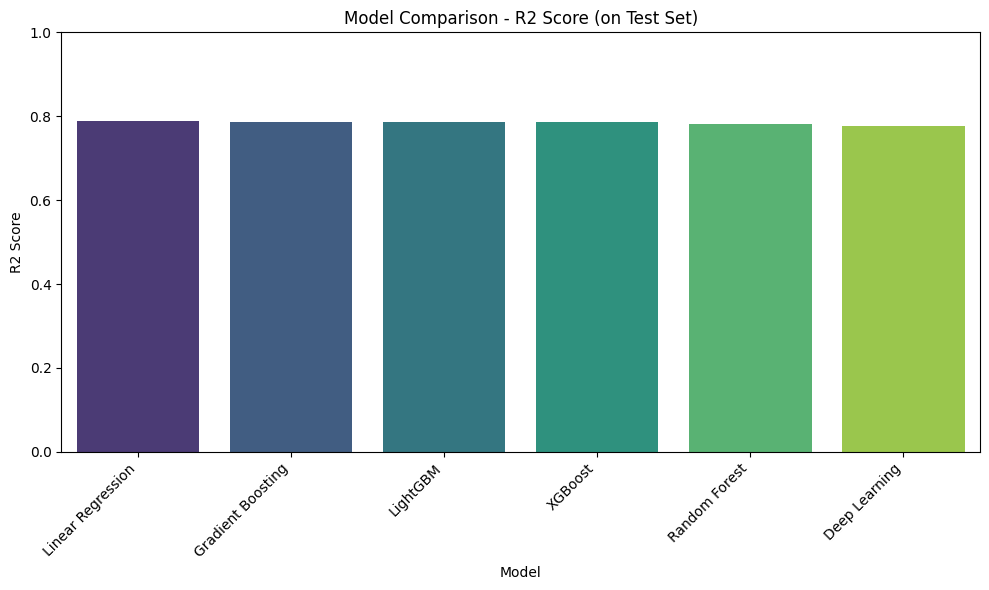


Plotting Model Comparison - MAPE (%) (on Test Set)


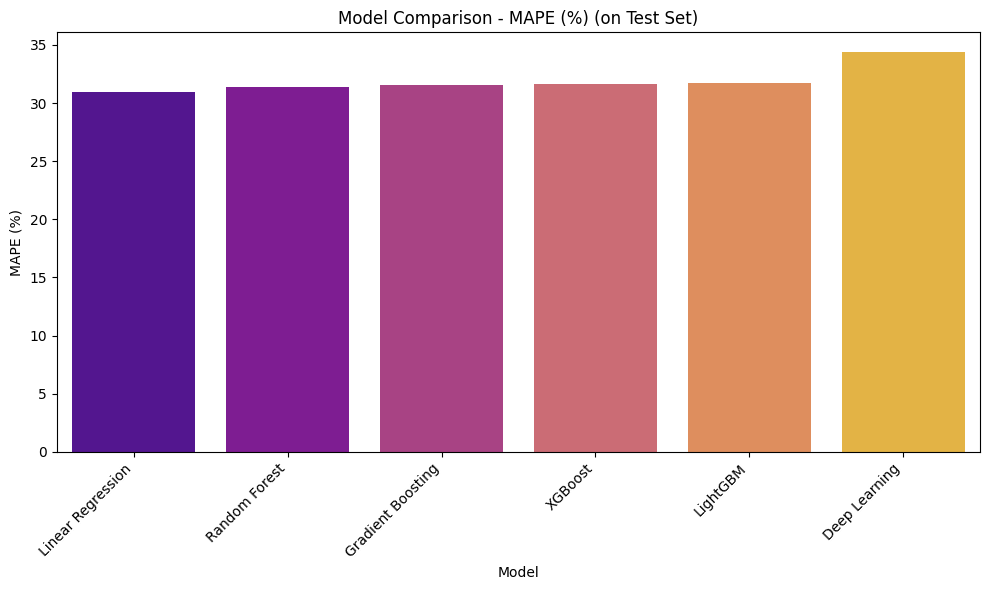

In [17]:
if df is not None: # Only proceed if data loaded successfully
    print("\n--- Model Accuracy Report (Evaluated on Test Set) ---")
    results = []
    for model_name, model in trained_models.items():
        if isinstance(model, Sequential):
            y_pred = model.predict(X_test_scaled_df).flatten()
        else:
            y_pred = model.predict(X_test_scaled_df)
        results.append(evaluate_model_metrics(model_name, y_test, y_pred))

    eval_df = pd.DataFrame(results)
    print("Note: Accuracy metrics (R2, MSE, MAE, MAPE) are calculated on the test set where actual salaries are known.")
    print(eval_df)

    print("\nPlotting Model Comparison - R2 Score (on Test Set)")
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='R2 Score', data=eval_df.sort_values(by='R2 Score', ascending=False), palette='viridis')
    plt.title("Model Comparison - R2 Score (on Test Set)")
    plt.ylabel("R2 Score")
    plt.xlabel("Model")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("\nPlotting Model Comparison - MAPE (%) (on Test Set)")
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='MAPE (%)', data=eval_df.sort_values(by='MAPE (%)'), palette='plasma')
    plt.title("Model Comparison - MAPE (%) (on Test Set)")
    plt.ylabel("MAPE (%)")
    plt.xlabel("Model")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


--- Prediction on New Data (Demonstration in Notebook) ---

'new_employees.csv' created for demonstration with 15 employees.
Predictions made by Linear Regression.
Predictions made by Random Forest.
Predictions made by Gradient Boosting.
Predictions made by XGBoost.
Predictions made by LightGBM.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Predictions made by Deep Learning.

All predictions for new employees:
       JobRole   Location  YearsExperience  PredictedSalary_LinearRegression  \
0         Lead  Hyderabad                5                      28118.569450   
1      Manager  Bangalore                8                      39944.253823   
2     Director       Pune               12                      53381.473010   
3      Analyst     Mumbai                2                      16468.604261   
4     Engineer    Chennai               15                      55112.386235   
5   Consultant      Delhi               20                      70092.786209   
6      Manager  Hyderabad       

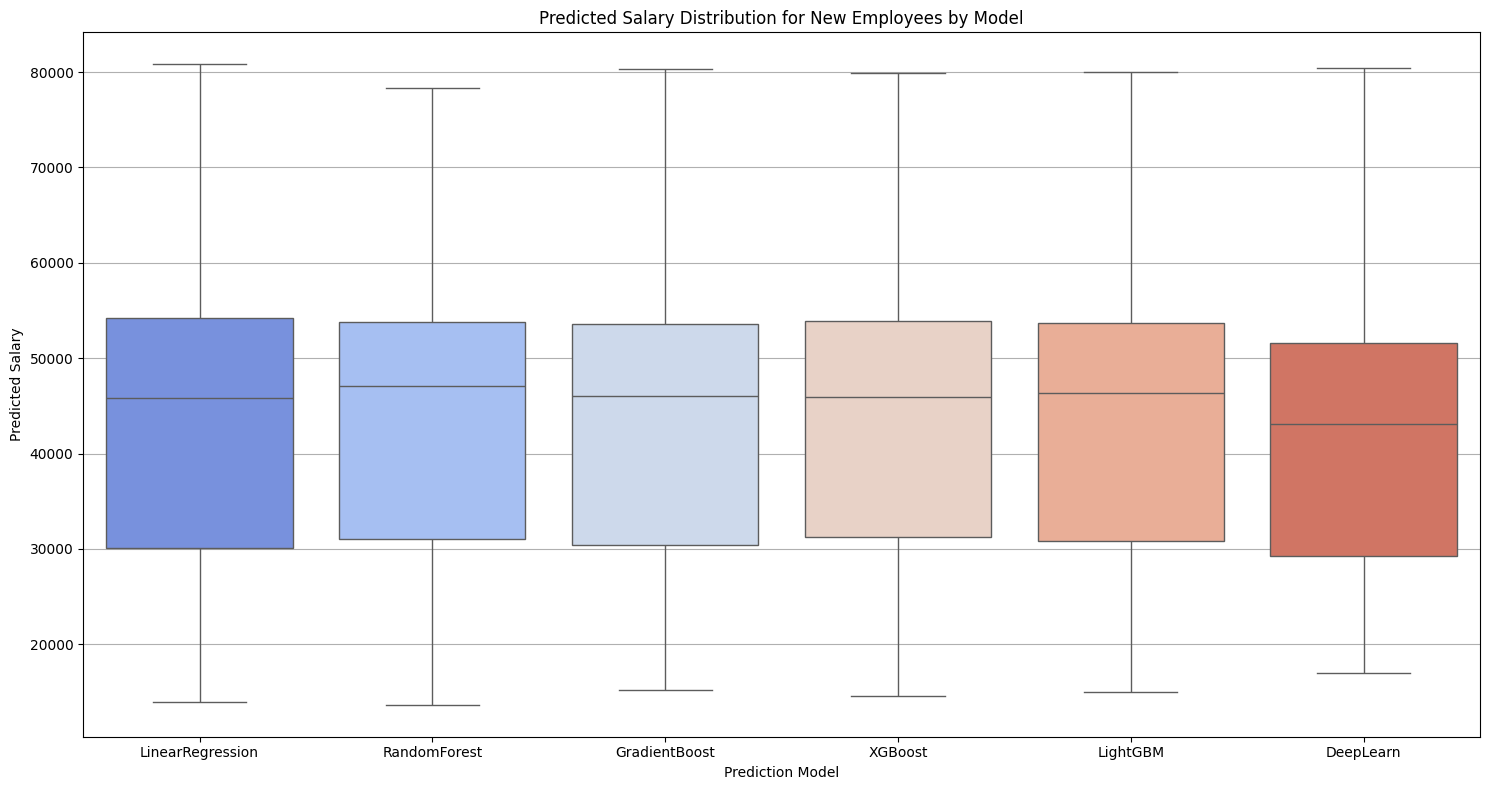

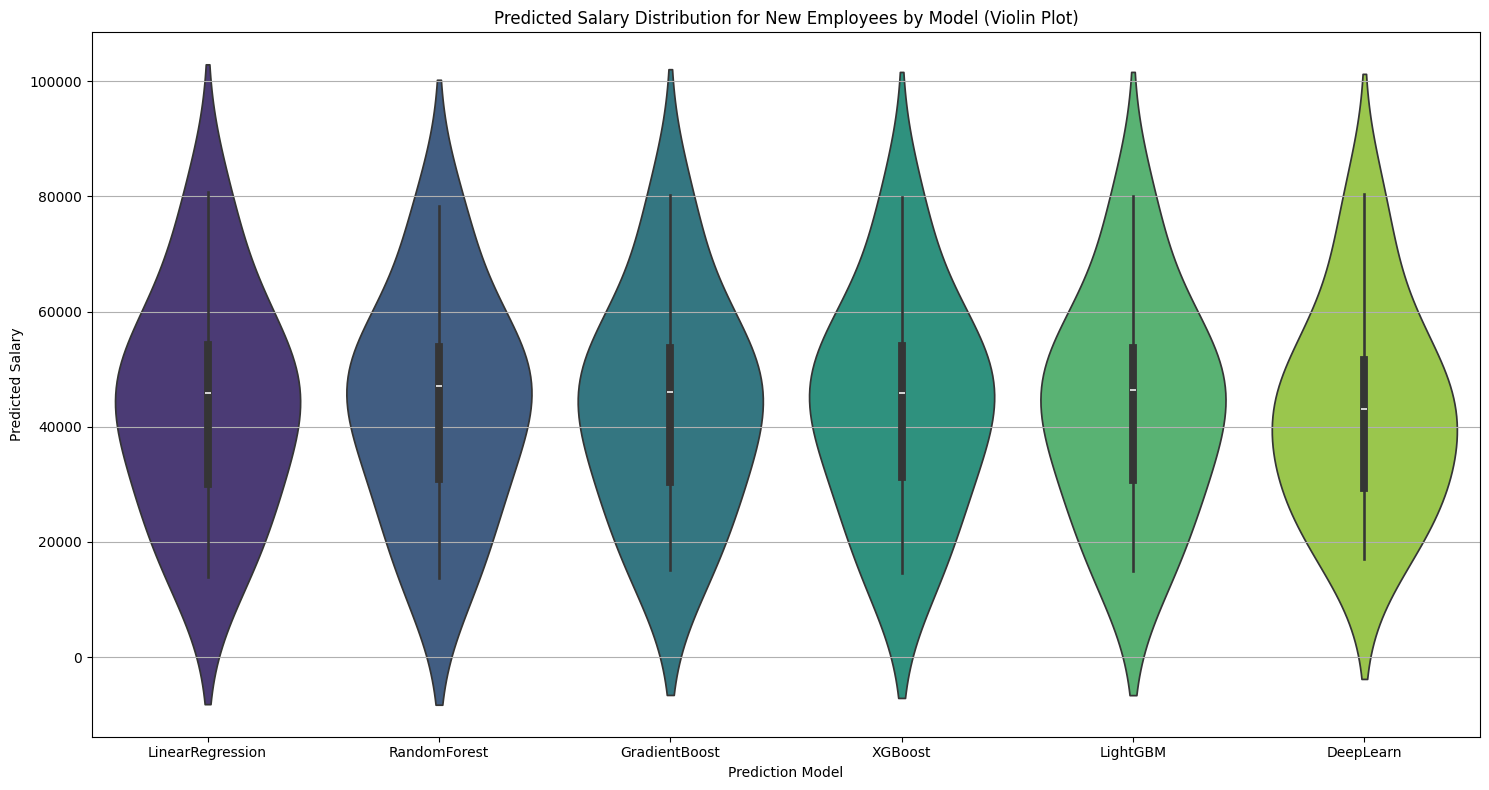

In [18]:
if df is not None: # Only proceed if data loaded successfully
    print("\n--- Prediction on New Data (Demonstration in Notebook) ---")
    new_employees_data = {
        'YearsExperience': [5, 8, 12, 2, 15, 20, 7, 10, 25, 3, 18, 6, 11, 14, 9],
        'EducationLevel': [3, 4, 5, 2, 4, 5, 3, 3, 5, 1, 4, 2, 4, 3, 5],
        'Age': [32, 39, 45, 25, 50, 55, 30, 35, 60, 28, 52, 29, 40, 48, 33],
        'JobRole': ['Lead', 'Manager', 'Director', 'Analyst', 'Engineer', 'Consultant', 'Manager', 'Engineer', 'Director', 'Analyst', 'Lead', 'Engineer', 'Consultant', 'Manager', 'Analyst'],
        'Location': ['Hyderabad', 'Bangalore', 'Pune', 'Mumbai', 'Chennai', 'Delhi', 'Hyderabad', 'Bangalore', 'Pune', 'Mumbai', 'Chennai', 'Delhi', 'Hyderabad', 'Bangalore', 'Pune'],
        'Certifications': [2, 3, 4, 1, 3, 5, 2, 2, 4, 1, 3, 1, 4, 3, 2],
        'PreviousCompanies': [1, 2, 3, 0, 2, 4, 1, 1, 3, 0, 2, 0, 3, 2, 1],
        'PerformanceRating': [4, 5, 4, 3, 5, 4, 3, 4, 5, 2, 4, 3, 5, 4, 3],
        'TechStack': ['Python', 'Java', 'SQL', 'JavaScript', 'Python', 'Java', 'SQL', 'JavaScript', 'Python', 'Java', 'SQL', 'JavaScript', 'Python', 'Java', 'SQL'],
        'Department': ['IT', 'Finance', 'Operations', 'HR', 'IT', 'Admin', 'Finance', 'Operations', 'HR', 'IT', 'Finance', 'Operations', 'HR', 'IT', 'Admin'],
        'WorkingHours': [45, 48, 50, 40, 42, 55, 46, 49, 52, 38, 47, 43, 51, 53, 44],
        'LeavesTaken': [5, 2, 8, 10, 3, 15, 6, 4, 12, 7, 5, 9, 11, 6, 8],
        'Gender': ['Male', 'Female', 'Other', 'Male', 'Female', 'Other', 'Male', 'Female', 'Other', 'Male', 'Female', 'Other', 'Male', 'Female', 'Other'],
        'EmploymentType': ['FullTime', 'Contract', 'PartTime', 'FullTime', 'Contract', 'PartTime', 'FullTime', 'Contract', 'PartTime', 'FullTime', 'Contract', 'PartTime', 'FullTime', 'Contract', 'PartTime'],
        'RemoteWork': [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
    }
    new_df = pd.DataFrame(new_employees_data)
    new_df.to_csv("new_employees.csv", index=False)
    print("\n'new_employees.csv' created for demonstration with 15 employees.")

    new_df_loaded = pd.read_csv("new_employees.csv")
    new_df_loaded.columns = new_df_loaded.columns.str.strip()

    new_df_loaded['Experience_Age_Ratio'] = new_df_loaded['YearsExperience'] / new_df_loaded['Age']
    new_df_loaded['Experience_Age_Ratio'].fillna(0, inplace=True)
    new_df_loaded['Total_Skills_Certifications'] = new_df_loaded['Certifications'] + new_df_loaded['EducationLevel']
    new_df_loaded['Productivity_Score'] = new_df_loaded['PerformanceRating'] * (new_df_loaded['WorkingHours'] / (new_df_loaded['LeavesTaken'] + 1e-6))
    new_df_loaded['Productivity_Score'].fillna(0, inplace=True)

    combined_for_encoding_inference = pd.concat([df.drop('Salary', axis=1), new_df_loaded], axis=0, ignore_index=True)
    encoded_input_full = pd.get_dummies(combined_for_encoding_inference, columns=categorical_cols, drop_first=True)
    X_new_processed = encoded_input_full.tail(len(new_df_loaded))

    X_new_aligned = X_new_processed.reindex(columns=train_cols, fill_value=0)
    X_new_scaled = scaler.transform(X_new_aligned)

    new_employee_predictions_df = new_df_loaded[['JobRole', 'Location', 'YearsExperience']].copy()
    for model_name, model_obj in trained_models.items():
        if isinstance(model_obj, Sequential):
            predictions = model_obj.predict(X_new_scaled).flatten()
        else:
            predictions = model_obj.predict(X_new_scaled)
        new_employee_predictions_df[f'PredictedSalary_{model_name.replace(" ", "")}'] = predictions
        print(f"Predictions made by {model_name}.")

    print("\nAll predictions for new employees:")
    print(new_employee_predictions_df)

    print("\nGenerating comparative visualization of predicted salaries for new employees...")
    print("Note: For new, unseen data without actual salaries, we cannot calculate accuracy metrics.")
    print("Instead, these visualizations show the distribution of predicted salaries by each model.")

    predictions_melted = new_employee_predictions_df.melt(
        id_vars=['JobRole', 'Location', 'YearsExperience'],
        var_name='Model',
        value_name='Predicted Salary'
    )
    predictions_melted['Model'] = predictions_melted['Model'].str.replace('PredictedSalary_', '').str.replace('Regress\w*', '').str.replace('ing', '')

    plt.figure(figsize=(15, 8))
    sns.boxplot(x='Model', y='Predicted Salary', data=predictions_melted, palette='coolwarm')
    plt.title('Predicted Salary Distribution for New Employees by Model')
    plt.xlabel('Prediction Model')
    plt.ylabel('Predicted Salary')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 8))
    sns.violinplot(x='Model', y='Predicted Salary', data=predictions_melted, palette='viridis')
    plt.title('Predicted Salary Distribution for New Employees by Model (Violin Plot)')
    plt.xlabel('Prediction Model')
    plt.ylabel('Predicted Salary')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [19]:
if df is not None: # Only save if data loaded successfully
    print("\nSaving model artifacts for Streamlit app...")

    # Save the best Random Forest model (assuming it's the chosen production model)
    joblib.dump(trained_models["Random Forest"], 'best_rf_model.pkl')
    print("Saved best_rf_model.pkl")

    # Save the StandardScaler
    joblib.dump(scaler, 'scaler.pkl')
    print("Saved scaler.pkl")

    # Save the list of training columns (important for consistent feature order in Streamlit)
    joblib.dump(train_cols.tolist(), 'train_columns.pkl')
    print("Saved train_columns.pkl")

    # Save the original dataframe (or unique categorical values) to guide Streamlit inputs
    # For simplicity, saving a small dummy df with all categorical options
    dummy_df_for_streamlit_options = df[categorical_cols.tolist()].drop_duplicates().reset_index(drop=True)
    joblib.dump(dummy_df_for_streamlit_options, 'categorical_options_df.pkl')
    print("Saved categorical_options_df.pkl")

    print("\nModel artifacts saved successfully! Download these files to run the Streamlit app.")




Saving model artifacts for Streamlit app...
Saved best_rf_model.pkl
Saved scaler.pkl
Saved train_columns.pkl
Saved categorical_options_df.pkl

Model artifacts saved successfully! Download these files to run the Streamlit app.
